<a href="https://colab.research.google.com/github/SahilCarterr/Convolution-Neural-Network-Basic-Models/blob/Updates/Food101/03_Using_Pytorch_Pretrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.Getting Setup

In [1]:
import torch
import torchvision
from torchvision import transforms
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [2]:
import matplotlib.pyplot as plt
!pip install torchinfo
from torchinfo import summary
!git clone https://github.com/SahilCarterr/Convolution-Neural-Network-Basic-Models

Cloning into 'Convolution-Neural-Network-Basic-Models'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 435 (delta 45), reused 107 (delta 39), pack-reused 317
Receiving objects: 100% (435/435), 95.18 MiB | 34.95 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [3]:
!mv Convolution-Neural-Network-Basic-Models/Food101/going_modular .
!rm -rf Convolution-Neural-Network-Basic-Models

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get data

In [5]:
import os
import zipfile

from pathlib import Path

import requests


data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"


if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)


    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/SahilCarterr/Convolution-Neural-Network-Basic-Models/raw/main/Food101/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)


    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)


    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

## 2.1 Creating a tranform for torchvision.model(Manual creation)

In [7]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [8]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79626681dbd0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = auto_transforms,
    batch_size = 32,
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79626681f8e0>,
 ['pizza', 'steak', 'sushi'])

# 3 Getting a pretrained Model

### 3.1 Setting up pretrained Model

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


### 3.2 Getting Summary of our model with `torchinfo.summary()`

In [13]:
summary(model = model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
      )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

### 3.3 Freezing the base model and changing the output layer to suit our needs

In [14]:
for param in model.features.parameters():
  param.requires_grad = False

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train Model

In [19]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
from going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
start_time = timer()
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)
end_time = timer()
print(f"[INFO] Total training time:{end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9131 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7911 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7462 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6372 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6260 | test_acc: 0.8561
[INFO] Total training time:7.770 seconds


## 5. Evaluate model by plotting loss curves

In [21]:
results

{'train_loss': [1.0923867970705032,
  0.8716838583350182,
  0.7648383378982544,
  0.7109112963080406,
  0.6255180239677429],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9131104548772176,
  0.7911403377850851,
  0.7461888988812765,
  0.6371903816858927,
  0.6259646415710449],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

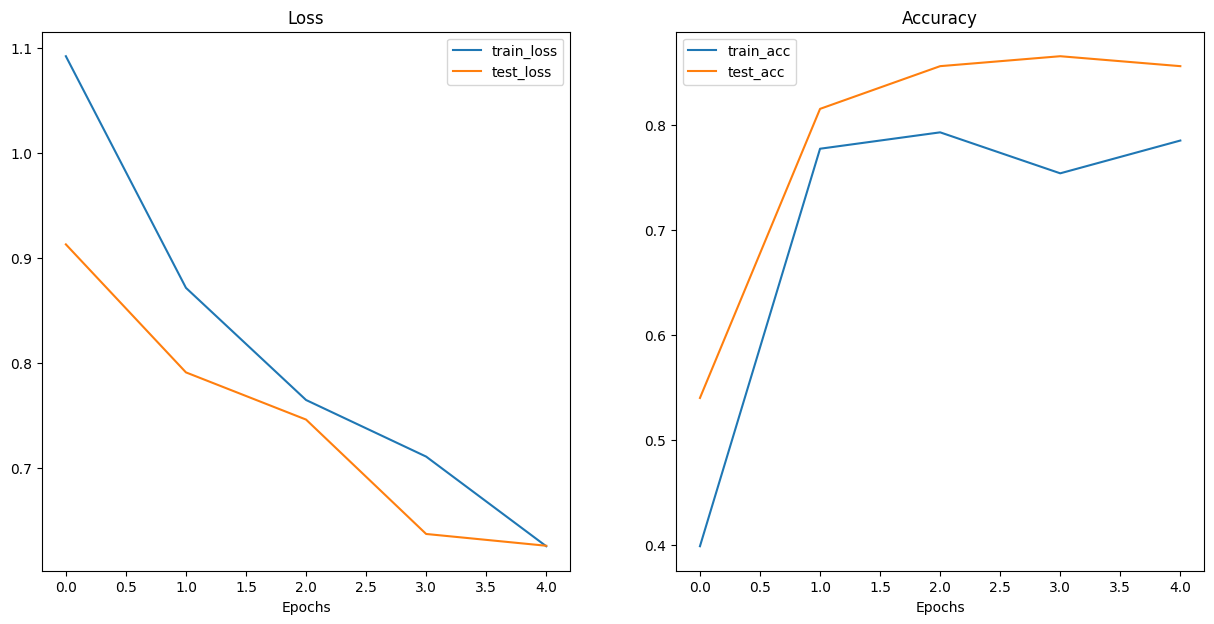

In [22]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(range(len(results["train_loss"])), results["train_loss"], label="train_loss")
plt.plot(range(len(results["train_loss"])), results["test_loss"], label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(results["train_acc"])), results["train_acc"], label="train_acc")
plt.plot(range(len(results["train_acc"])), results["test_acc"], label="test_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [23]:
from typing import List, Tuple
from PIL import Image
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob:{target_image_pred_probs.max():.3f}")
  plt.axis(False)

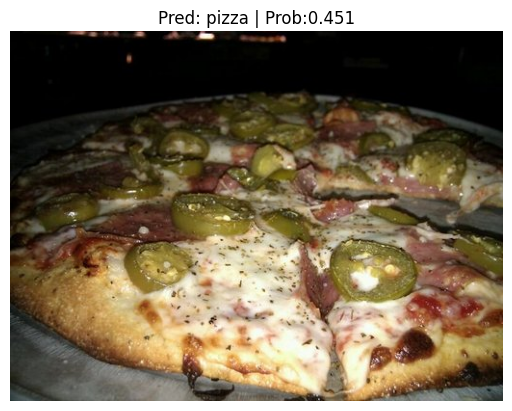

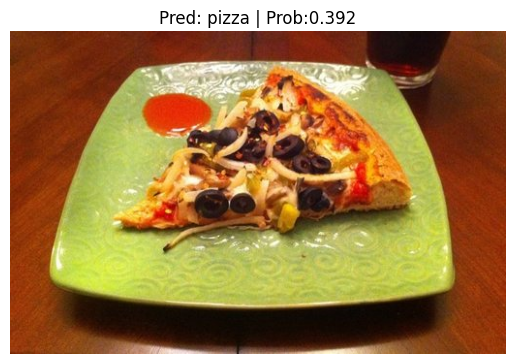

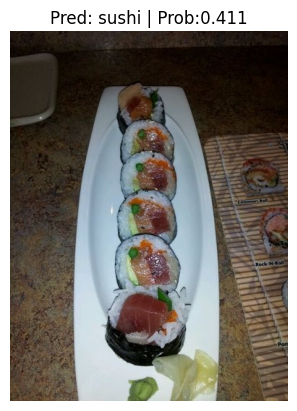

In [24]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list, k= num_images_to_plot)
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names)

In [25]:
!wget https://i.pinimg.com/736x/79/34/69/7934692a76c4db8bd1c28d2cfcc10872.jpg -O new_img.jpg

--2024-04-21 07:54:02--  https://i.pinimg.com/736x/79/34/69/7934692a76c4db8bd1c28d2cfcc10872.jpg
Resolving i.pinimg.com (i.pinimg.com)... 146.75.92.84, 2600:1406:5400::170f:f1db, 2600:1406:5400::170f:f1d1
Connecting to i.pinimg.com (i.pinimg.com)|146.75.92.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111332 (109K) [image/jpeg]
Saving to: ‘new_img.jpg’

new_img.jpg         100%[===================>] 108.72K  --.-KB/s    in 0.02s   

2024-04-21 07:54:02 (6.76 MB/s) - ‘new_img.jpg’ saved [111332/111332]



In [26]:
custom_image_path = "new_img.jpg"

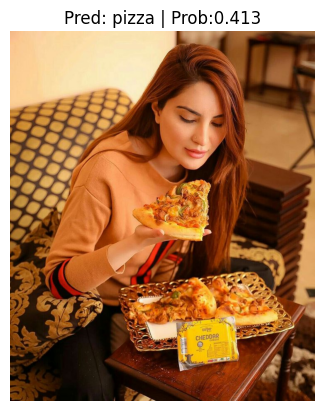

In [27]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)